# XO-1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
name = 'XO-1'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [5]:
obs = om.Observation.from_files(fnames)

In [6]:
obs

XO-1 [1 Visits]

In [7]:
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans().flatten(501)
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

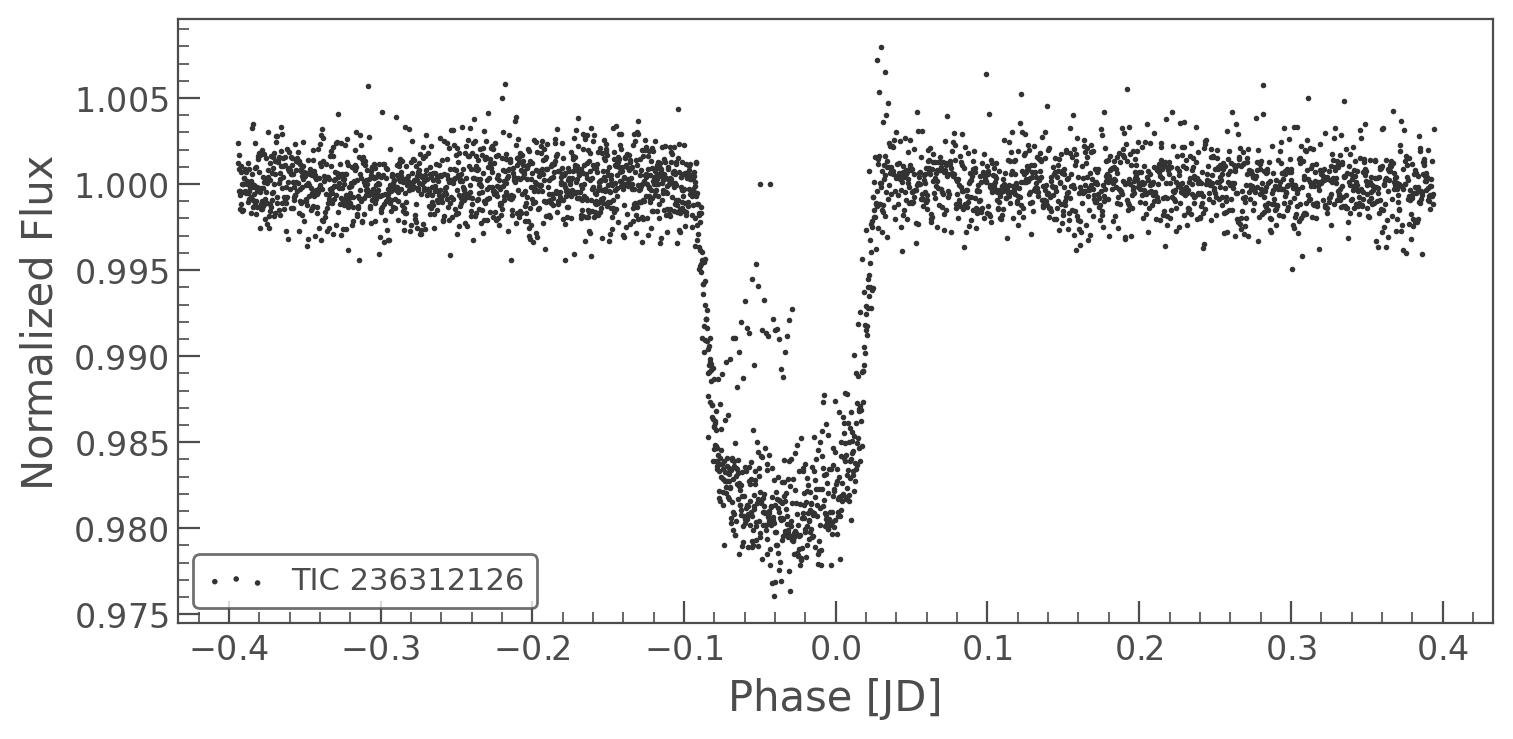

In [8]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [9]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

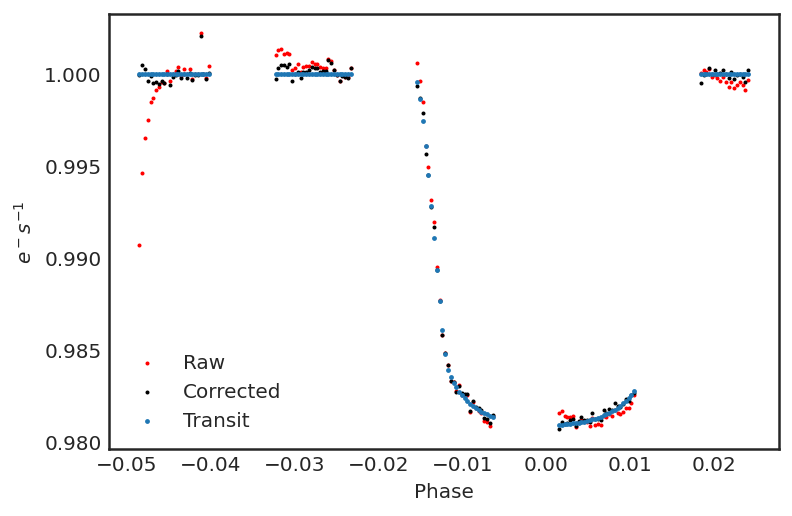

In [10]:
obs.plot()

In [11]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model: 100%|██████████| 1/1 [00:09<00:00,  9.67s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]

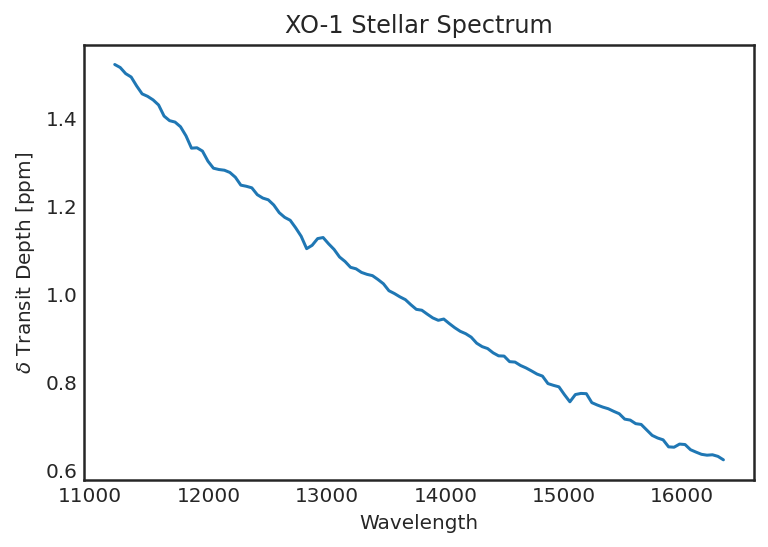

In [12]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

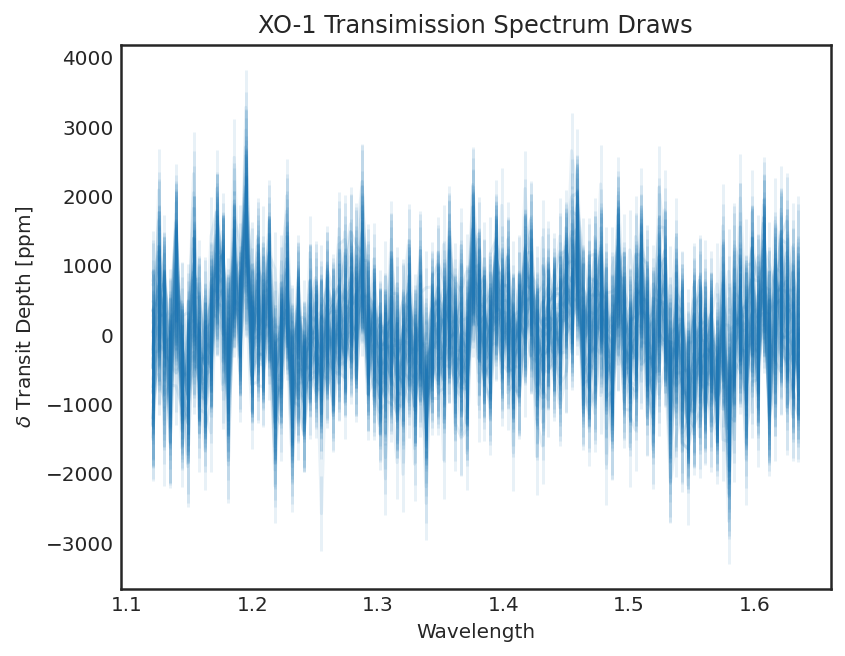

In [13]:
obs.plot_spectra()

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

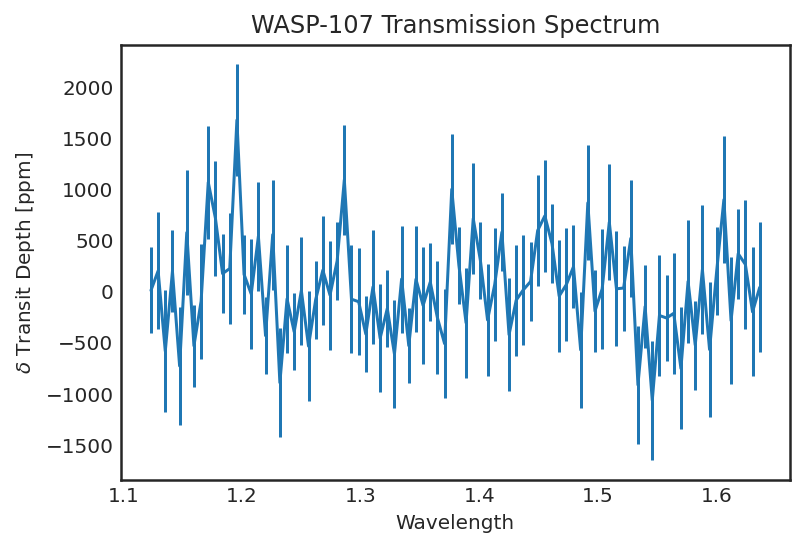

In [14]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [15]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

In [16]:
from astropy.io import fits
fits.open('results/XO-1_transmission.fits')[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                  112 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = 'D       '                                                            
TUNIT1  = 'um      '                                                            
TTYPE2  = 'spectrum'                                                            
TFORM2  = 'D       '        

In [17]:
obs[0].propid, obs[0].time[0], obs[0].time[-1], len(obs[0].time)

(12181, 2455834.66208719, 2455834.9478742247, 128)

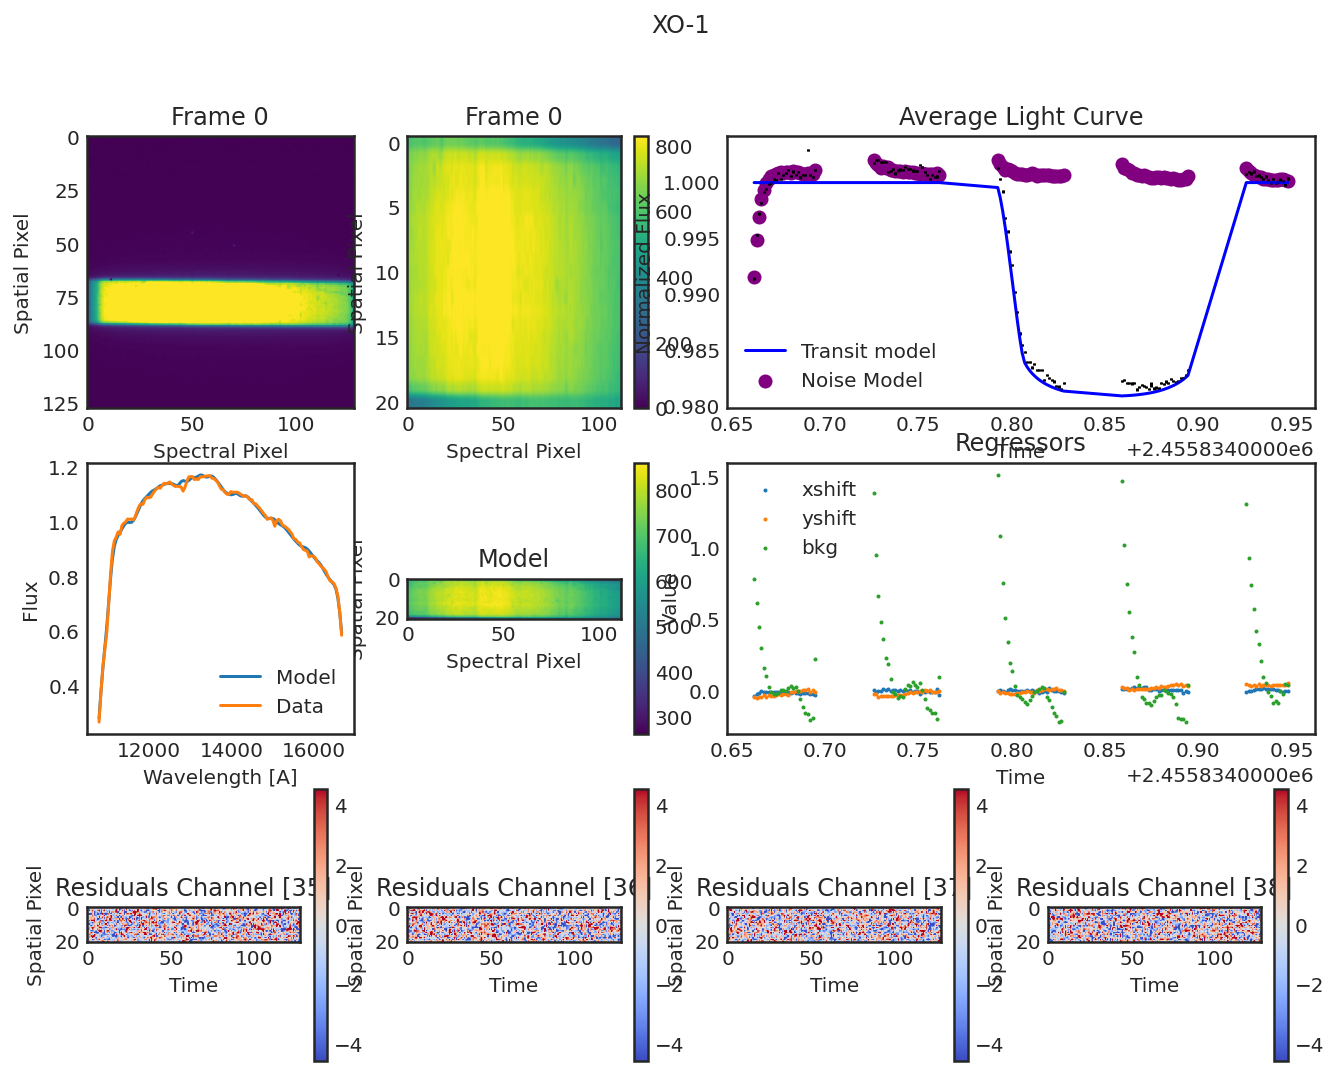

In [18]:
for visit in obs:
    visit.diagnose();
    plt.show();